# Density Estimation & Clustering

*N. Pol (2025)*

This lecture and notebook are based on the "DensityEstimation" and "DE2andClustering" lectures of of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540).

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 6.

---

## Contents
* [Density Estimation](#one)
    * [Non-parametric density estimation](#onea)
    * [Parametric density estimation](#oneb)
* [Clustering Algorithms](#two)
    * [$K$-means](#twoa)
    * [Mean-shift](#twob)
* [Correlation functions](#three)
    
---

***Exercises required for class participation are in <font color='red'>red</font>.***

---

## Density Estimation <a class="anchor" id="one"></a>

Inferring the pdf of a sample of data is known as ***density estimation***. Essentially we are smoothing the data to correct for the finiteness of our sample and to better recover the underlying distribution.

Density estimation is useful because:
- identifying low probability regions can help uncover rare sources. 
- if the data can be divided into sub-samples, one can estimate the pdf for each subsample and, in turn determine classifications for new objects.

### Non-parametric Density Estimation <a class="anchor" id="onea"></a>

*Nonparametric* density estimation is useful when we know nothing about the underlying distribution of the data, since we don't have to specify a functional form. This flexibility allows us to capture the shape of the distribution well, at the expense of more difficulty interpreting the results.

#### Kernel Density Estimation (KDE)

[*Kernel Density Estimation (KDE)*](https://en.wikipedia.org/wiki/Kernel_density_estimation) is the standard approach for non-parametric density estimation.

Let's start by recalling some problems with making simple histograms.

In [1]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#------------------------------------------------------------
# Draw some random data
np.random.seed(1)
x = np.concatenate([np.random.normal(-0.5, 0.3, size=14), 
                    np.random.normal(1, 0.3, size=7)])

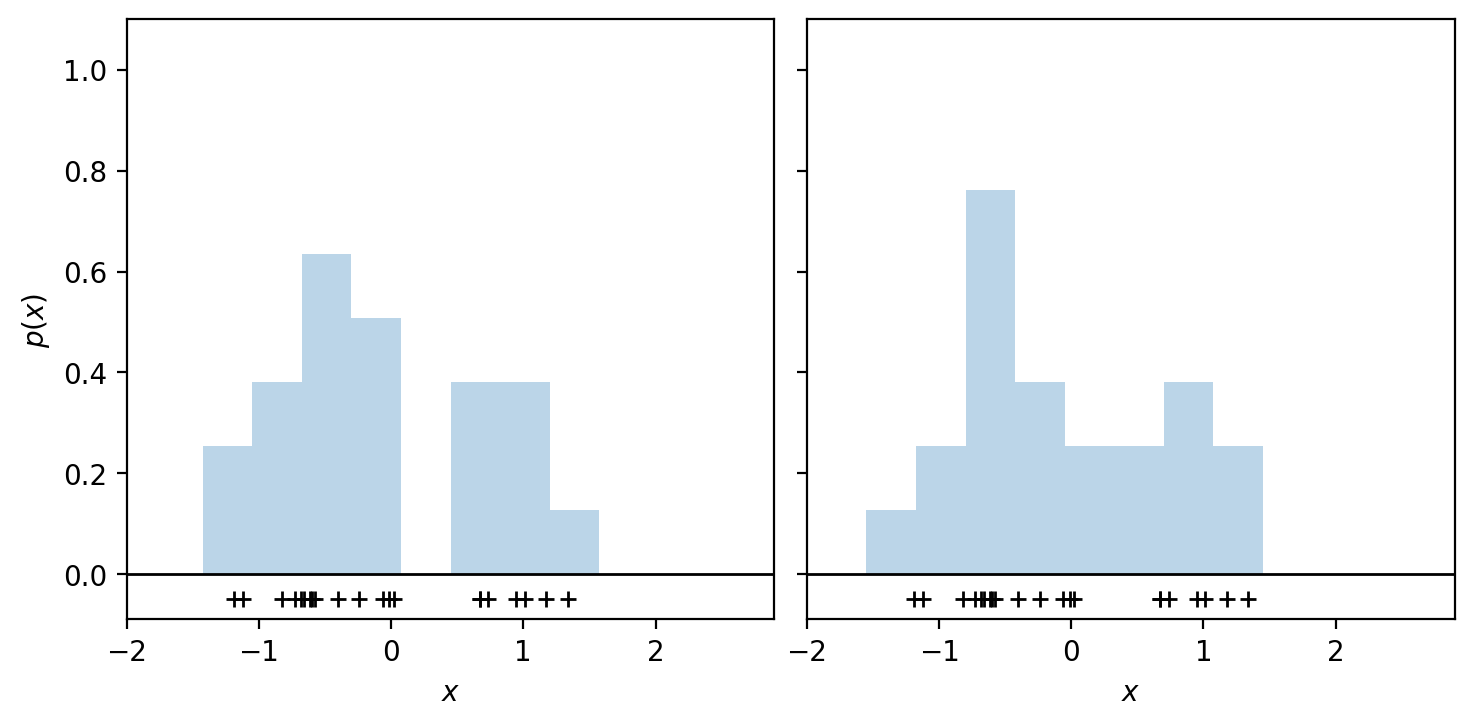

In [3]:
# Modified from Ivezic, Figure 6.1, modified by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#------------------------------------------------------------

# First figure: silly histogram binning
fig1 = plt.figure(figsize=(8, 4))
fig1.subplots_adjust(left=0.12, right=0.95, wspace=0.05, 
                     bottom=0.15, top=0.9, hspace=0.05)

FC = '#6666FF'
XLIM = (-2, 2.9)
YLIM = (-0.09, 1.1)

ax = fig1.add_subplot(121)
bins = np.linspace(-1.8, 2.7, 13)
ax.hist(x, bins=bins, density=True, 
        histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

#Shift bin centers by 0.25
ax = fig1.add_subplot(122)
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.hist(x, bins=bins + 0.25, density=True, 
        histtype='stepfilled', fc='k', alpha=0.3)
ax.plot(XLIM, [0, 0], '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')

plt.show()

The data points that make up the histogram are the same in both panels.  All we have done is shifted the locations of the bins by 0.25. ***The choice of number of bins and the location of bin centers can really change the histogram that we make.***

The next panels are what happens if we center the bins on each point. This is an example of **kernel density estimation** using a "***top-hat***" kernel. It is a good description of the data, but pretty ugly.

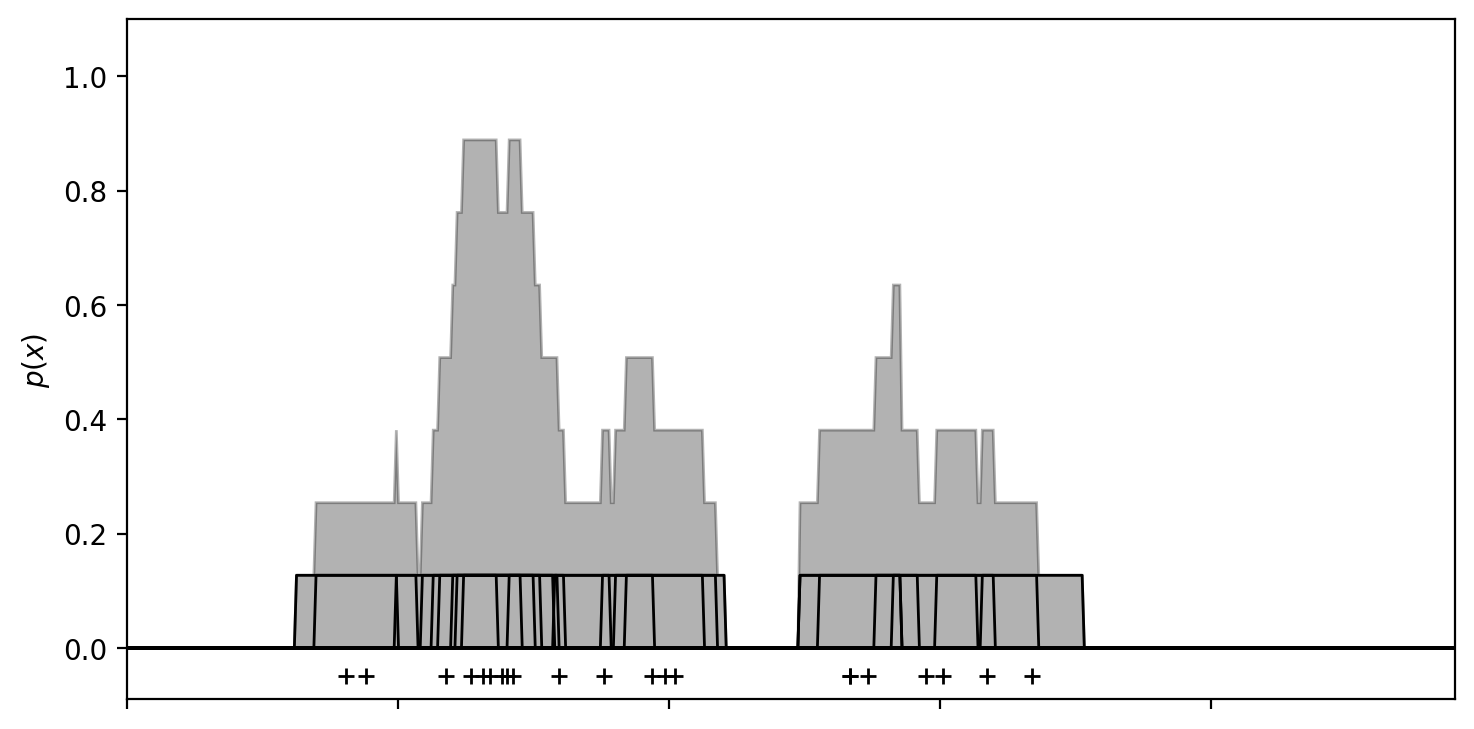

In [4]:
fig1b = plt.figure(figsize=(8, 4))
fig1b.subplots_adjust(left=0.12, right=0.95, wspace=0.05, 
                      bottom=0.1, top=0.95, hspace=0.05)

ax = fig1b.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = (abs(x_plot - x[:, None]) <= 0.5 * binwidth).astype(float)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_ylabel('$p(x)$')
plt.show()

We can make it look nicer by choosing a different kernel, i.e. a different bin shape. The next plot shows a **KDE using a Gaussian kernel**.

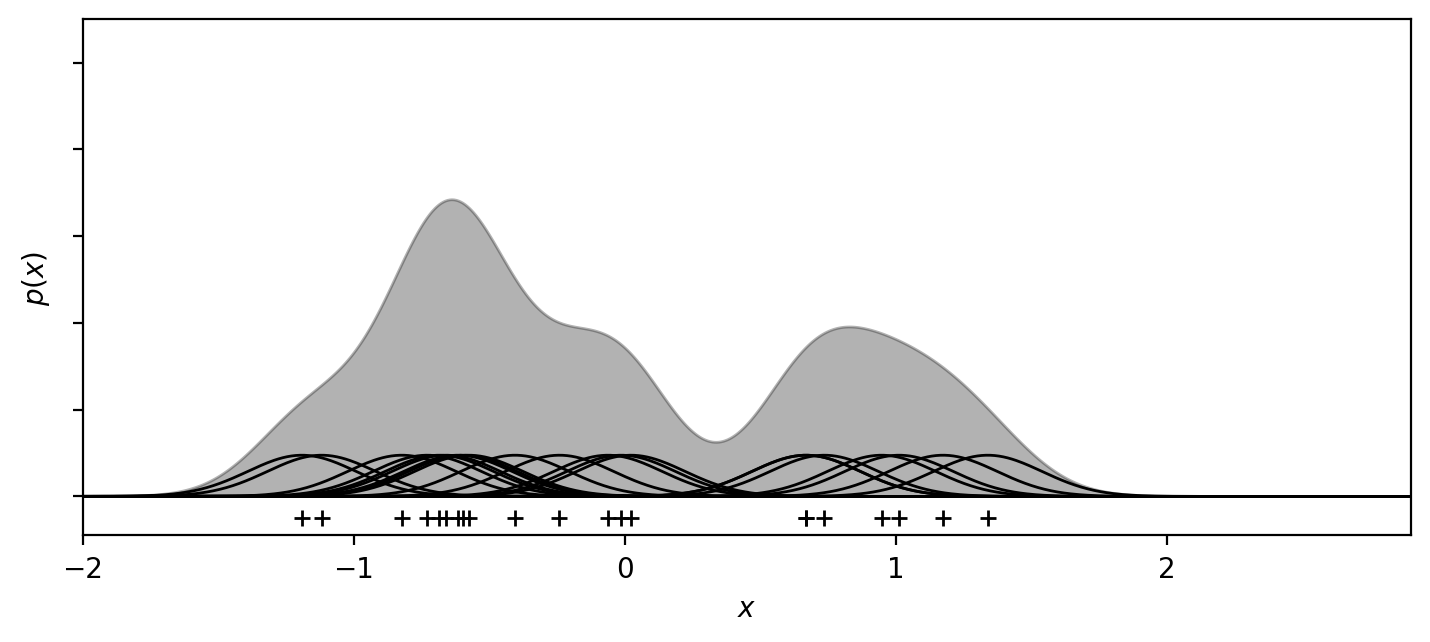

In [5]:
#------------------------------------------------------------
# First figure: transition to KDE
fig2 = plt.figure(figsize=(8, 8))
fig2.subplots_adjust(left=0.12, right=0.95, wspace=0.05, 
                     bottom=0.0, top=1.0, hspace=0.05)

## Just right
ax = fig2.add_subplot(313)
ax.yaxis.set_major_formatter(plt.NullFormatter())
binwidth = bins[1] - bins[0]
x_plot = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_plot, x[:, None], 0.2)
y_plot /= (binwidth * len(x))
ax.fill(x_plot, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_plot, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')
ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
plt.show()

We can think of KDE as replacing the points with "clouds". Each cloud is described by the kernel $K(u)$, where $K(u)$ can be any function that is:
- smooth,
- postive definite,
- normalizes to unity, 
- has zero mean,
- has positive variance. 

A common kernel is the **Gaussian kernel** that we just used above:

$$ K(u) = \frac{1}{(2\pi)^{D/2}}\exp{(-u^2/2)}$$

where $D$ denotes the dimensionality of the data. Once a kernel is chosen the KDE at a point, $x$, is given by 

$$ \hat{f}(x) = \frac{1}{Nh^D}\sum_{i=1}^N K\left(\frac{d(x,x_i)}{h}\right),$$

where $\hat{f}$ is an ***estimator*** of our distribution.

The argument of $K$ is just some measure of the distance between $x$ and each $x_i$. Normally $d(x,x_i) = (x-x_i)$. For the gaussian kernel that makes $h=\sigma$. So, $h$ represents the "width" or what is usually called the **"bandwidth"** in this context.

Here is a comparison of some different possible kernels.

![Ivezic, Figure 6.2](http://www.astroml.org/_images/fig_kernels_1.png)

**The Epanechnikov kernel is "optimal" because it minimizes the variance of the kernel density estimate**: 

$$K(x) = \frac{3}{4}(1-x^2),$$

for $|x|\le 1$ and 0 otherwise. Below is the code that produces the plot above.  

<font color='red'>Add the Epanechnikov kernel to it in the color and linestyle of your choice by modifying the cell below.</font>

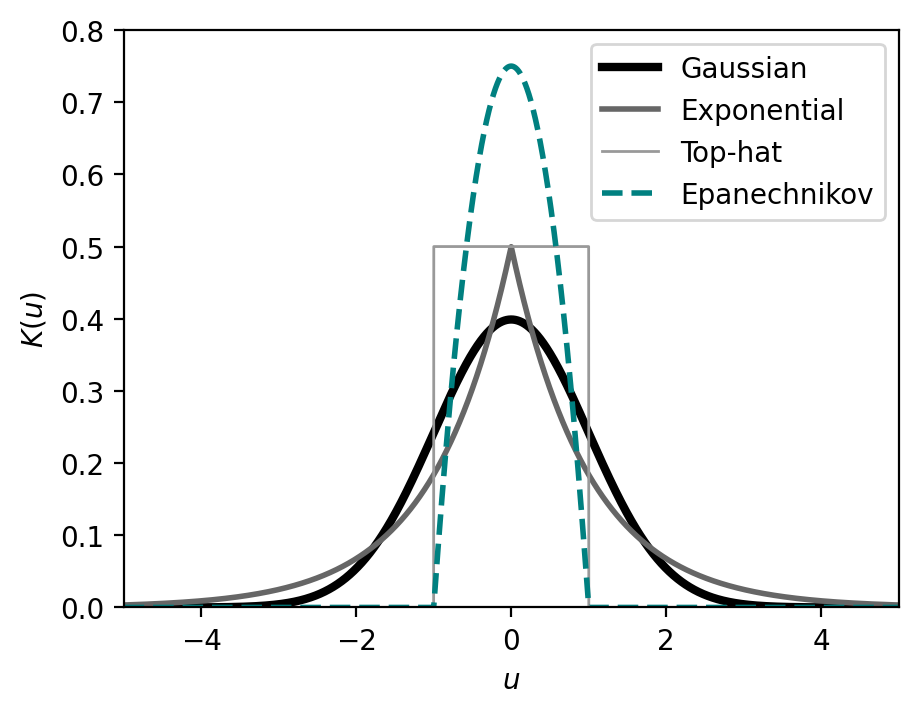

In [6]:
#------------------------------------------------------------
# Compute Kernels.
xgrid = np.linspace(-5, 5, 10000)
dx = xgrid[1] - xgrid[0]

# Gaussian kernel
gauss = (1. / np.sqrt(2 * np.pi)) * np.exp(-0.5 * xgrid ** 2)

# Exponential kernel
exp = 0.5 * np.exp(-abs(xgrid))

# Top-hat kernel
tophat = 0.5 * np.ones_like(xgrid)
tophat[abs(xgrid) > 1] = 0 # Range of the tophat kernel

# Epanechnikov kernel 
ep =0.75 * (1 - xgrid**2) # Add the Epanechnikov kernel function
ep[abs(xgrid) > 1] = 0 # Set the range of the kernel

#------------------------------------------------------------
# Plot the kernels
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

ax.plot(xgrid, gauss, '-', c='black', 
        lw=3, label='Gaussian')
ax.plot(xgrid, exp, '-', c='#666666', 
        lw=2, label='Exponential')
ax.plot(xgrid, tophat, '-', c='#999999', 
        lw=1, label='Top-hat')
# Add the Epanechnikov kernel to the plot
ax.plot(xgrid,ep,'--',c='teal',lw=2,label='Epanechnikov')  

ax.legend(loc=1)

ax.set_xlabel('$u$')
ax.set_ylabel('$K(u)$')

ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.8001)
plt.show()

#### How do we determine the optimal kernel bandwidth?

When we first discussed histograms and KDE we talked about theoretical computation of optimal bandwidths.  Let's now look at how we can empirically determine the optimal bandwidth through [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).

To avoid fooling ourselves into thinking our model is better than it is, we set aside some of the data as the "***test***" set--that provides an independent check on the the fit from the ***training data***. 

That's fine if our model has no parameters, or has parameters that are all fixed ahead of time.  But what if we want to try to use the data to not only fit a model, but decide what the best model parameters are?  In that case, we need to set aside some of the training data as a "***validation***" set.  

However, not only does that leave us even less data for training, but it also means that it matters which objects are in each of the training, validation, and test sets.  We can solve both of these problems with **cross validation**.

With our KDE example, we are just trying to map the density, not predict the value, so we really only need two sets: training and validation. There are a number of different ways to do this.

1. You could **randomly sample** to decide which data goes into the training or test sets. We don't just do this once, but rather many times so that each data point is treated both as a training point and as a test point at some stage.


2. We could do this in a more ordered way (e.g., to make sure that each object gets sampled as training/test the same number of times) and do a **$K$-fold cross validation**. Here $K$ is the number of "experiments" that need to be done so that each data point appears in a test sample once.


3. We can take $K$-fold cross validation to the extreme by having $K\equiv N$, so that in each experiment we leave out just one object. This is called **"Leave-One-Out" cross validation**.

Let's go back to our problem of trying to determine the best bandwidth for our Kernel Density Estimate. <font color='red'>We can do this in Scikit-Learn with [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and replot our histogram above as follows:</font>

In [7]:
# Complete and Execute this cell to determine the bandwidth
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

bwrange = np.linspace(0.1, 1.0, 30) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) # Try each bandwidth with K-folds
grid.fit(x[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.1310344827586207


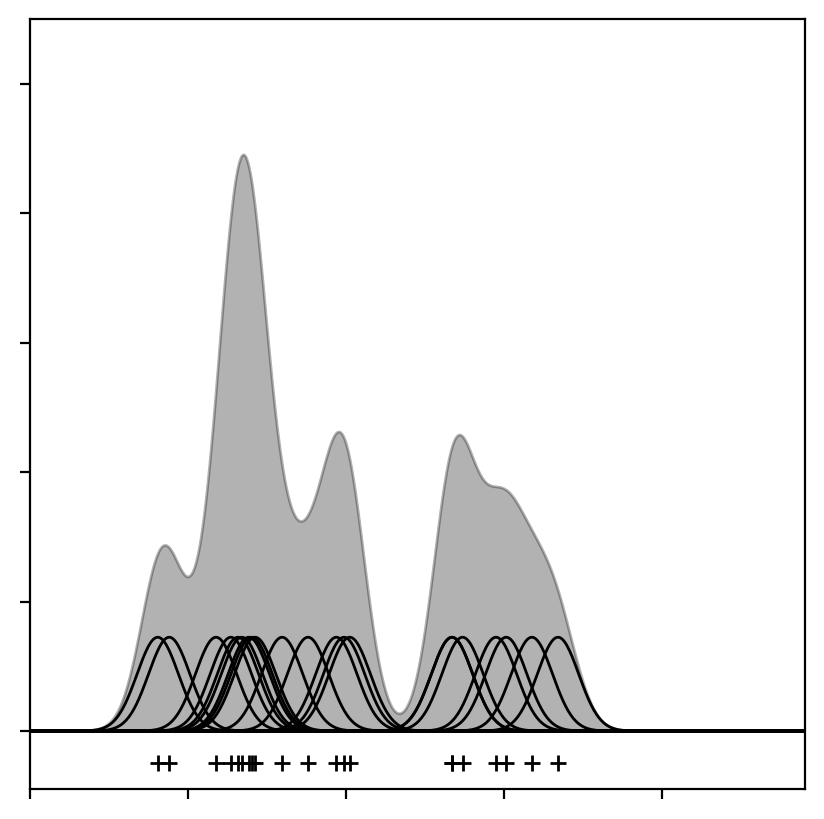

In [8]:
# Execute this cell to see the new "histogram"
fig2 = plt.figure(figsize=(5, 5))
ax = fig2.add_subplot(111)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

binwidth = bins[1] - bins[0]
x_grid = np.linspace(-4, 4, 1000)
y_plot = binwidth * stats.norm.pdf(x_grid, x[:, None], h_opt)
y_plot /= (binwidth * len(x))

ax.fill(x_grid, y_plot.sum(0), ec='k', lw=1, fc='k', alpha=0.3)
ax.plot(x_grid, y_plot.T, '-k', lw=1)
ax.plot(x, 0 * x - 0.05, '+k')

ax.set_xlim(XLIM)
ax.set_ylim(YLIM)
plt.show()

#### 2-D Histograms

Here is some sample code using [`sklearn.neighbors.KernelDensity`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html).  Play around with this and see how it works.  Make different variations of the plot.  (For example, try `bandwidth=0.01` and `bandwidth=1.0`.)  What we are doing here is using KDE to set the plot color to indicate the relative density of the points.  This is essentially a 2-D histogram.

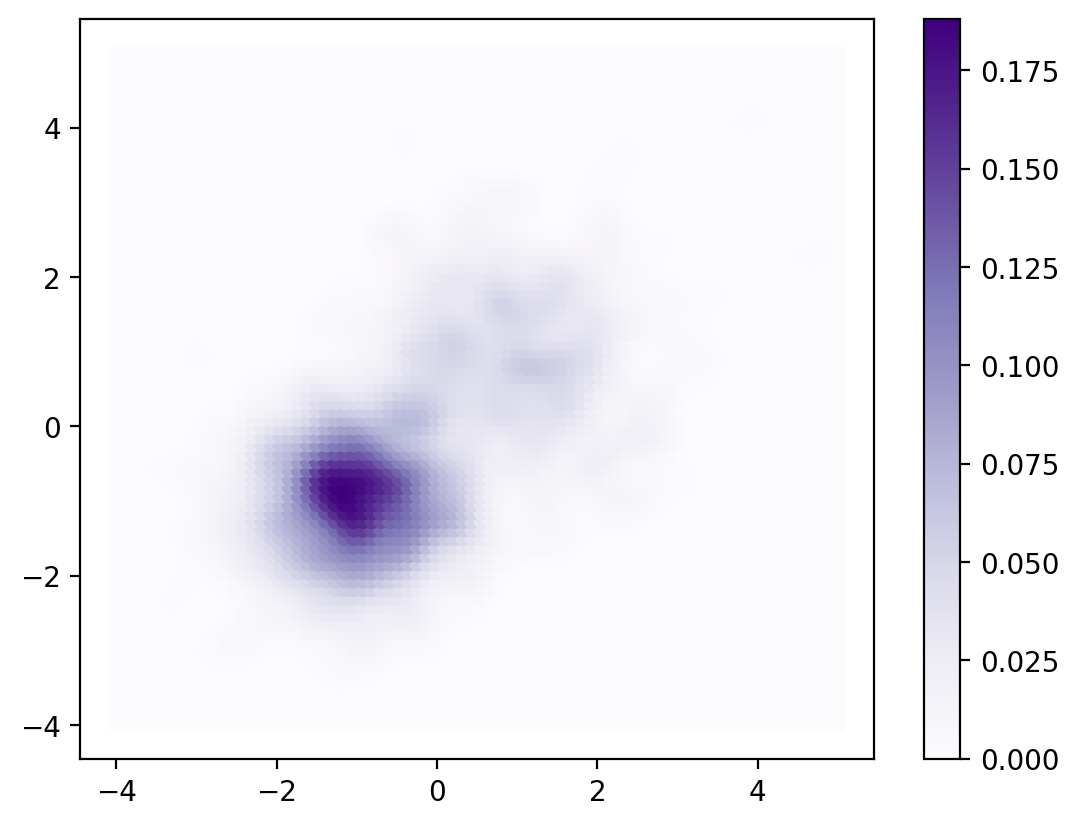

In [9]:
from sklearn.neighbors import KernelDensity

# Two 2-D normal distributions with offset centroids
# See what happens when you make changes to the next 2 lines.
X = np.concatenate([np.random.normal([-1,-1],[0.75,0.75], size=(1000,2)), 
                    np.random.normal([1,1],[1,1], size=(500,2))]) 
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde.fit(X) #fit the model to the data

u = v = np.linspace(-4,5,80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar()
plt.show()

<font color='red'>Now copy the example from above to a new cell and splice in the cross validation code to produce a new plot with the "optimal" bandwidth.  Basically, splice in the lines of code for `GridSearchCV` between the lines setting `X` and instantiating `kde`.  Then replace the hardcoded bandwidth with the optimal value you computed.</font>

Optimal Bandwidth: 0.41034482758620683


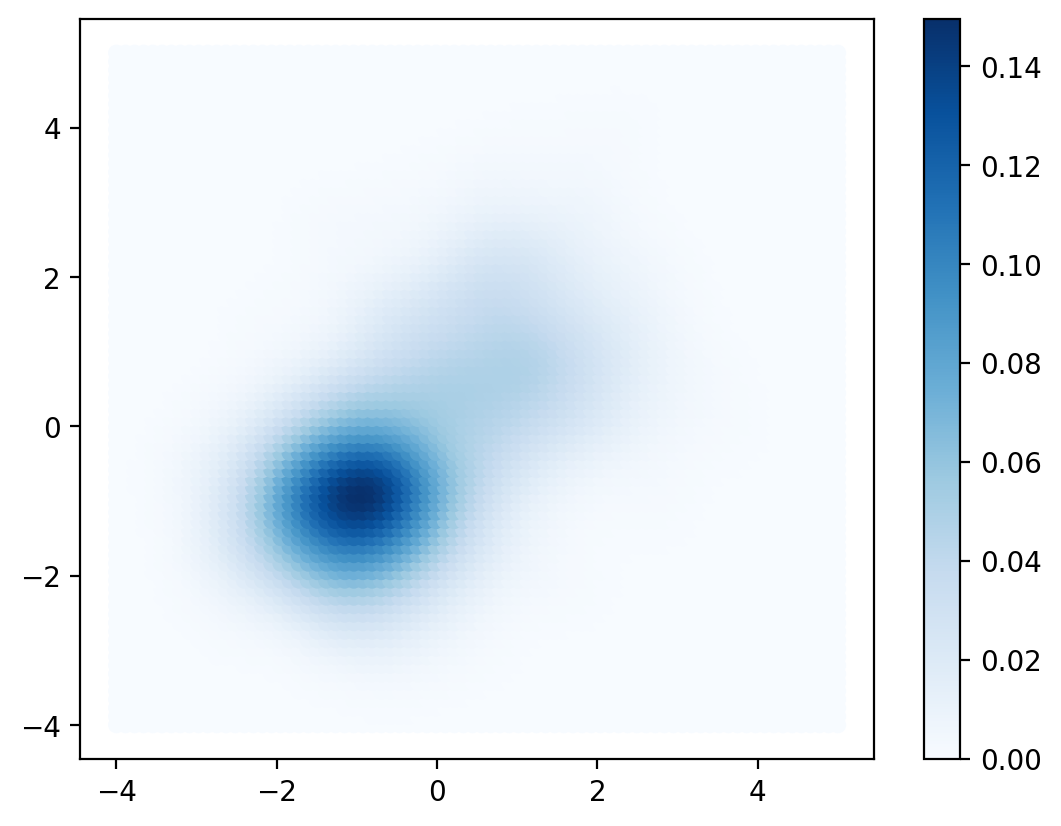

In [10]:
from sklearn.neighbors import KernelDensity

# Two 2-D normal distributions with offset centroids
# See what happens when you make changes to the next 2 lines.
X = np.concatenate([np.random.normal([-1,-1],[0.75,0.75], size=(1000,2)), 
                    np.random.normal([1,1],[1,1], size=(500,2))]) 

bwrange = np.linspace(0.05, 1.0, 30)  # Test 30 bandwidths from 0.05 to 1.0
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bwrange}, cv=5)
grid.fit(X)


h_opt = grid.best_params_['bandwidth']
print(f"Optimal Bandwidth: {h_opt}")

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) #fit the model to the data

u = v = np.linspace(-4,5,80)
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Blues", edgecolor="None")
plt.colorbar()
plt.show()

---

#### Nearest-Neighbor Density Estimation

Another very simple way to estimate the density of an $N$-dimensional distribution is to look to the nearest object (or the $K$ nearest objects) and compute their distances, $d_K$.  This is the [$K$-Nearest Neighbor](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) algorithm. The density at a given point, $x$ is estimated as

$$\hat{f}_K(x) = \frac{K}{V_D(d_K)},$$

where $V_D(d)$ is given generically by $\frac{2d^D\pi^{D/2}}{D\Gamma(D/2)}$ where $\Gamma$ is the complete gamma function, and this formula reduces to the usual equations for area and volume in 2 and 3 dimensions, respectively.

We can simplify this to 

$$\hat{f}_K(x) = \frac{C}{d_K^D}$$

since the constant, $C$ can be evaluated at the end.

This estimator has some intrinsic bias, which can be reduced by considering *all* $K$ nearest neighbors:
$$\hat{f}_K(x) = \frac{C}{\sum_{i=1}^K d_i^D}$$

See the [Scikit-Learn `neighbors` documentation](http://scikit-learn.org/stable/modules/neighbors.html) for more information.

Ivezic, Figure 6.5 compares a Nearest Neighbor ($k=10$) with a KDE algorithm. <font color='red'>See what happens as you increase the number of neighbors used.</font>

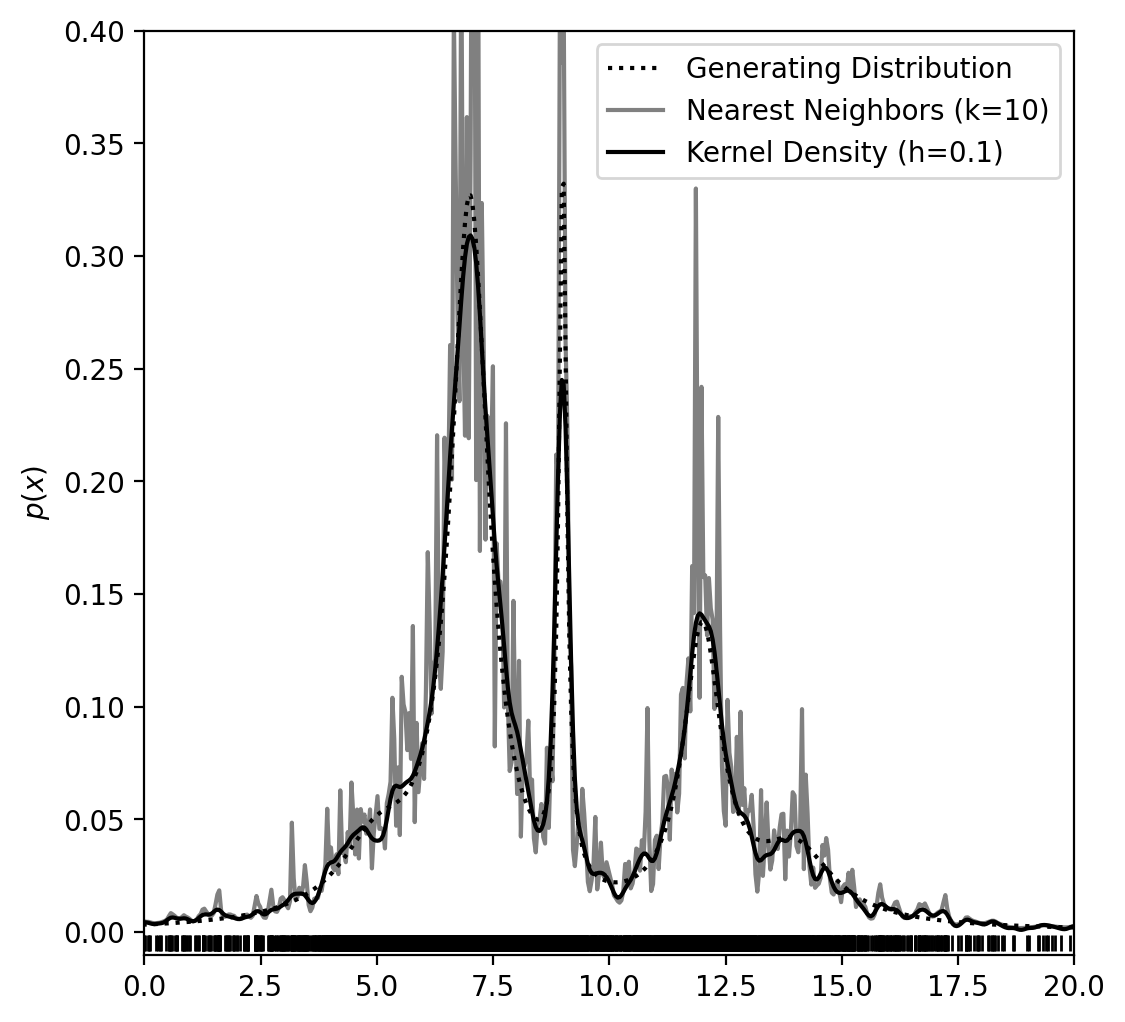

In [11]:
# Based on Ivezic, Figure 6.5
# Modified by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
#  this is the same data used in the Bayesian Blocks figure
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x) 
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N)) 
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(6, 6))
N = 5000
k = 10 #Number of neighbors

xN = x[:N]
t = np.linspace(-10, 30, 1000)

# Compute density with KDE
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(xN[:, None])
dens_kde = np.exp(kde.score_samples(t[:, None]))

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(xN[:, None])
dens_nbrs = nbrs.eval(t[:, None]) / N

# plot the results
plt.plot(t, true_pdf(t), ':', color='black', 
         zorder=3, label="Generating Distribution")
plt.plot(xN, -0.005 * np.ones(len(xN)), '|k')
plt.plot(t, dens_nbrs, '-', lw=1.5, color='gray', 
         zorder=2, label="Nearest Neighbors (k=%i)" % k)
plt.plot(t, dens_kde, '-', color='black', 
         zorder=3, label="Kernel Density (h=0.1)")

# label the plot
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')
plt.xlim(0, 20)
plt.ylim(-0.01, 0.4001)

plt.show()

### Parametric Density Estimation <a class="anchor" id="oneb"></a>

#### Gaussian Mixture Models (GMM)

KDE centers each bin (or rather, kernel) at each point.  In a [**mixture model**](https://en.wikipedia.org/wiki/Mixture_model) we don't use a kernel for each data point, but rather we fit for the ***locations of the kernels*** in addition to the width. So a mixture model is sort of a hybrid between a tradtional (fixed bin location/size) histogram and KDE. 

- Using lots of kernels (maybe even more than the BIC score suggests) may make sense if you just want to provide an accurate description of the data (as in density estimation).  
- Using fewer kernels makes mixture models more like clustering (later today), where the suggestion is still to use many kernels in order to divide the sample into real clusters and "background".

Gaussians are the most commonly used components for mixture models.  So, the pdf is modeled by a sum of Gaussians:

$$p(x) = \sum_{k=1}^N \alpha_k \mathscr{N}(x|\mu_k,\Sigma_k),$$

where $\alpha_k$ are the "mixing coefficients" with $0\le \alpha_k \le 1$ and $\sum_{k=1}^N \alpha_k = 1$.

We can solve for the parameters using maximum likelihood analyis as we have discussed previously.
However, this can be complicated in multiple dimensions, requiring the use of [**Expectation Maximization (EM)**](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm) methods (see textbook for details).

Ivezic Figure 4.2 (next cell) provides an example in 1-D.

/opt/anaconda3/envs/astr3300/lib/python3.12/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


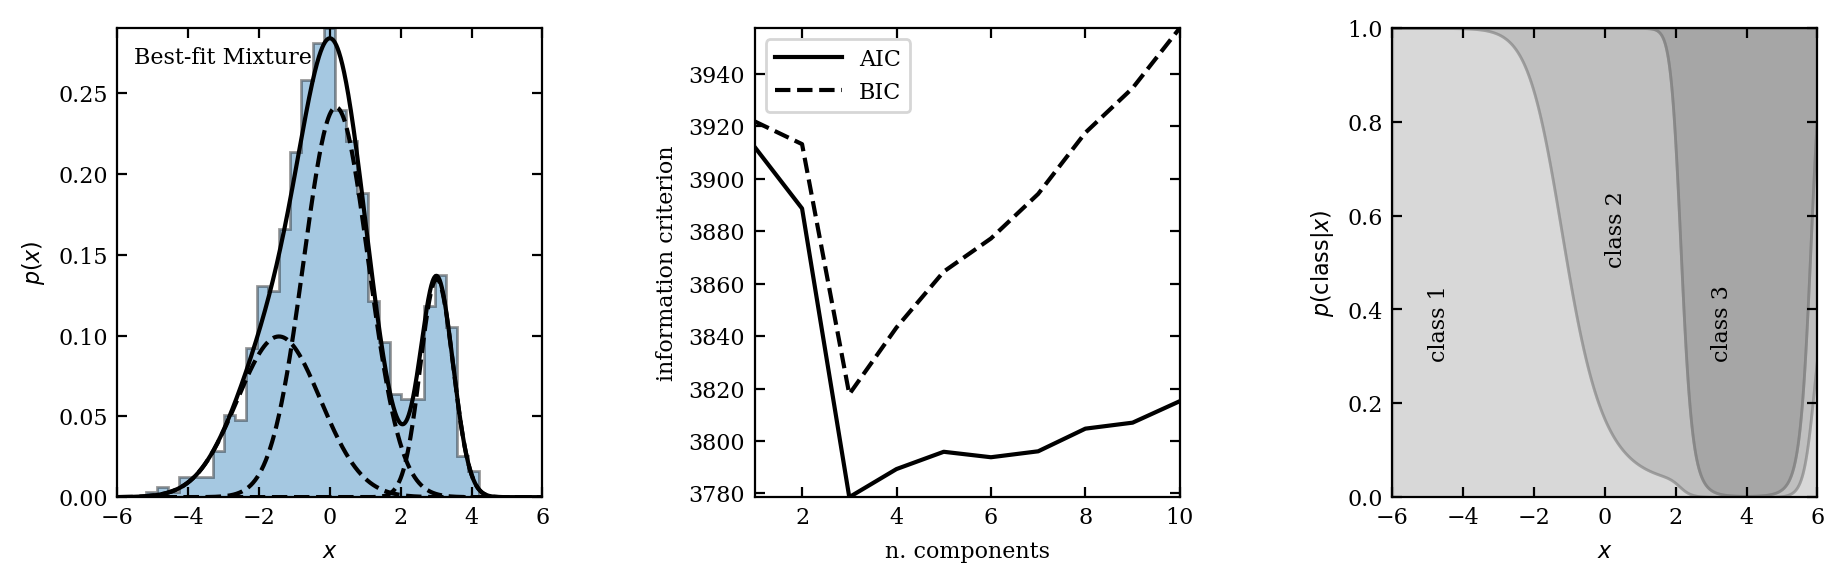

In [12]:
# Ivezic v2, Figure 4.2
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.

random_state = np.random.RandomState(seed=1)

X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(10, 3.4))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)
M_best = models[np.argmin(AIC)]

x = np.linspace(-6, 6, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()

Let's try a simpler example so you can see exactly how to use GMM. We'll fit a two-dimensional distribution composed of two Gaussian distributions using GMMs with varying numbers of components. The BIC will tell us how many components are favored:

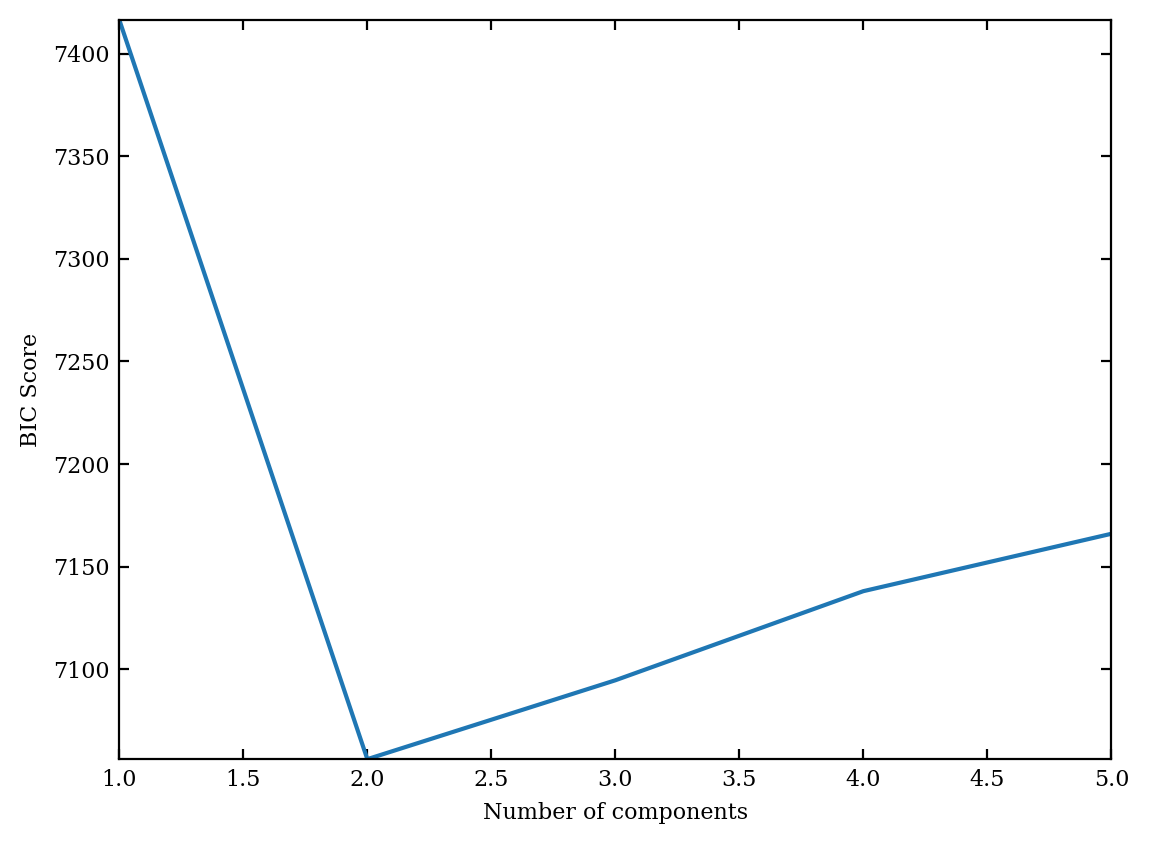

In [13]:
# Execute this cell
import numpy as np
from sklearn.mixture import GaussianMixture

X = np.concatenate([np.random.normal(size=(500,2)),
                   np.random.normal(loc=3.0, size=(500,2))]) # 1000  points in 2D
BIC = []
for ii in range(1,6):
    gmm = GaussianMixture(ii) #three components
    gmm.fit(X)
    log_dens = gmm.score(X)
    BIC.append(gmm.bic(X))
    
plt.plot(np.arange(1,6), BIC);
plt.xlabel('Number of components');
plt.ylabel('BIC Score');
plt.show()

Do the results make sense?

## Clustering <a class="anchor" id="two"></a>

> *[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) algorithms attempt to group together similar objects in a data set.* 

This process allows us to put new objects into the resulting classes and to identify rare objects that do not fit any particular mold. **Clustering is inherently an "unsupervised" process** as we do not know the classification of the objects. Since we have no metric for determining when we are right, it is a bit of a dark art, but it also can be very powerful. Scikit-Learn's clustering suite is summarized at [http://scikit-learn.org/stable/modules/clustering.html](http://scikit-learn.org/stable/modules/clustering.html).

### $K$-Means Clustering <a class="anchor" id="twoa"></a>

We start with [$K$-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), which is one of the simplest methods.  $K$-means seeks to minimize the following

$$\sum_{k=1}^{K}\sum_{i\in C_k}||x_i - \mu_k||^2$$

where $\mu_k = \frac{1}{N_k}\sum_{i\in C_k} x_i$

In words, this says to
  * Take every object in class $C_k$ (as determined by which centroid it is closest to, specifically $C_k(x_i) = \arg \min_k ||x_i-\mu_k||)$
  * Compute the mean of the objects in that class
  * Subtract that mean from each member of that class and square the norm
  * Do that for each class and sum
  * Shift the centroids of the *pre-determined* number of classes until this sum is minimized
  * Do this multiple times with different starting centroids and take the result with the minimum sum
  
A typical call will look something like this

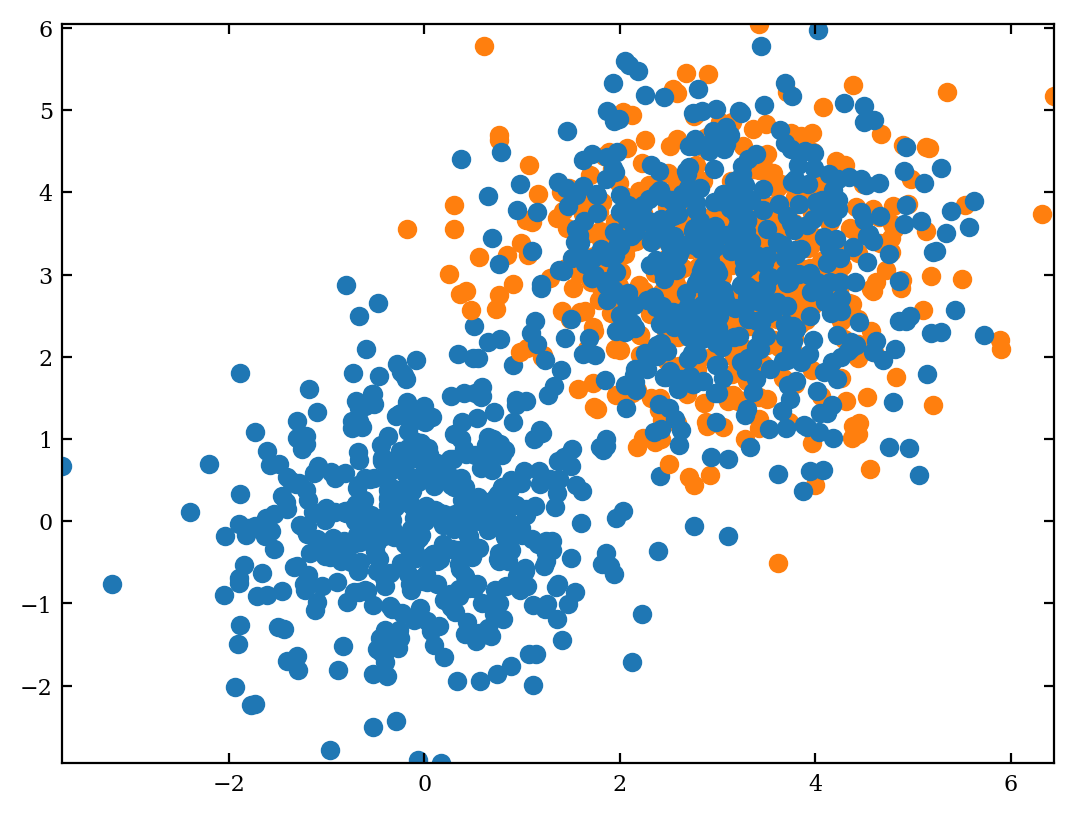

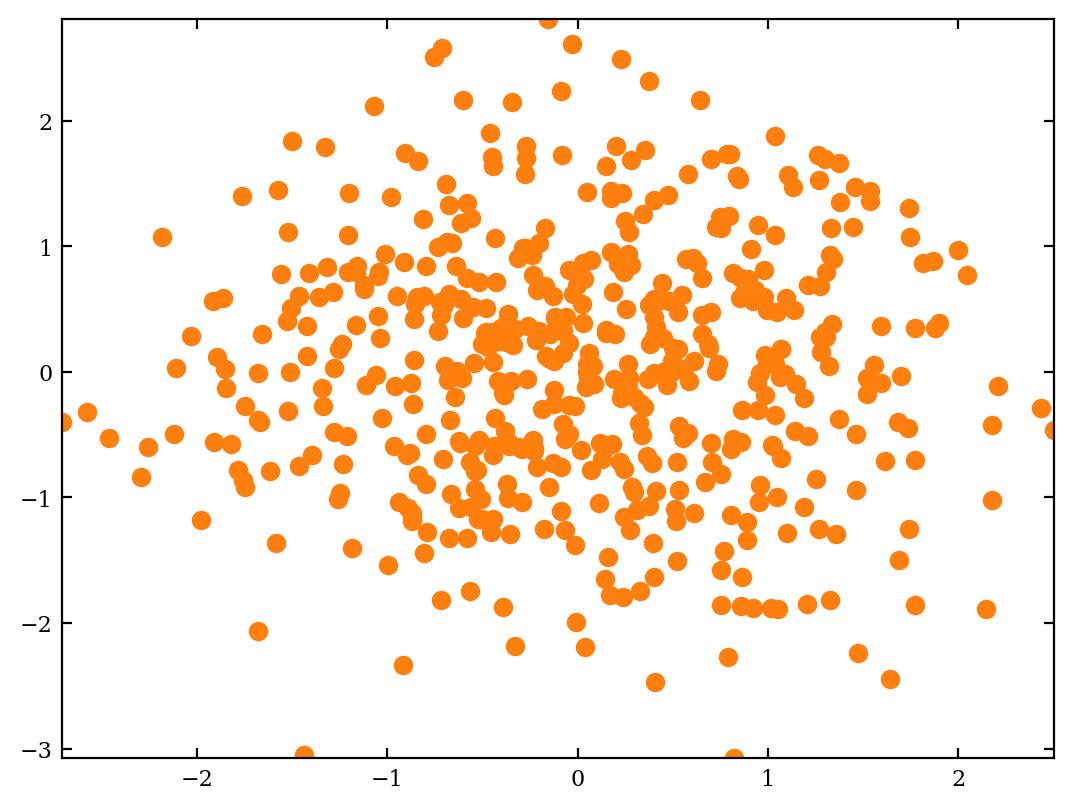

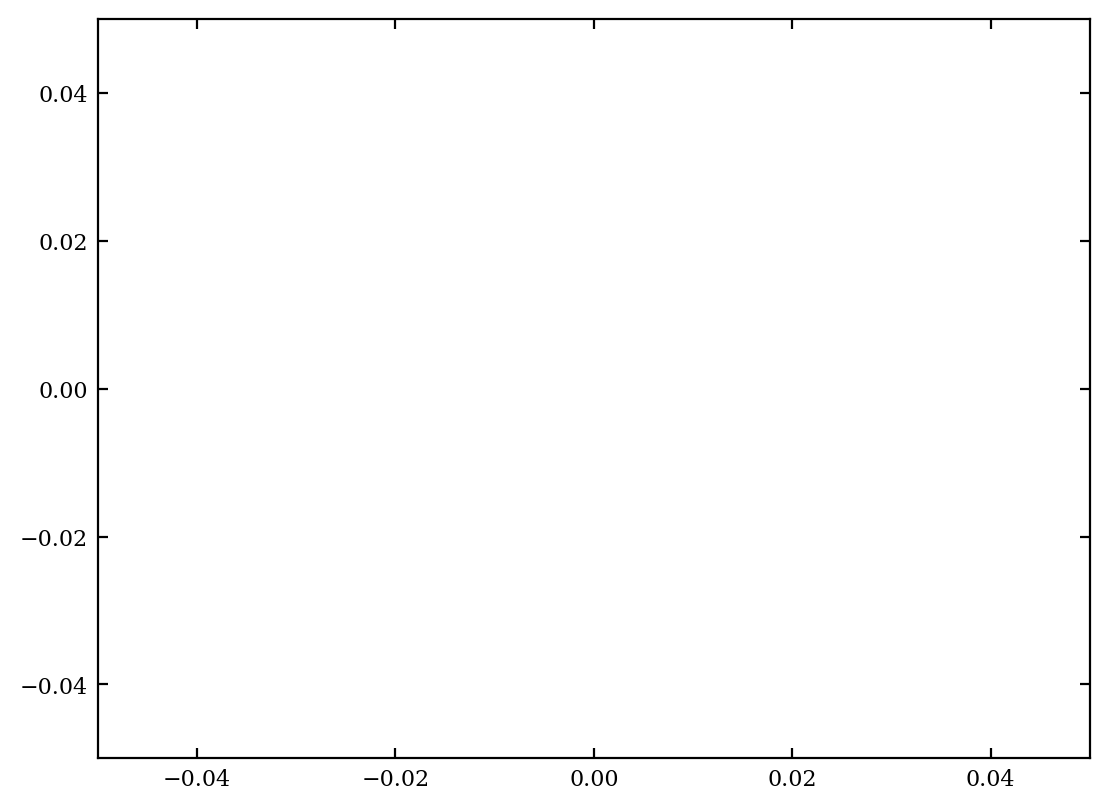

In [15]:
# Execute this cell
from sklearn.cluster import KMeans
from sklearn import preprocessing

#X = np.random.normal(size=(1000,2)) #1000 points in 2D
X = np.concatenate([np.random.normal(size=(500,2)),
                   np.random.normal(loc=3.0, size=(500,2))]) # 1000  points in 2D
clf = KMeans(n_clusters=2) #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C0', 'C1', 'C2']
for ii in range(3):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii])
    plt.show()

# To get some information on these try:
# KMeans?
# help(clf)

In [16]:
X[labels[0],0]

-0.37797521982175075

Here is an example of **K-means clustering on some multi-dimensional data**. The example and data derive from G. Richards' lecture "DE2andClustering.ipynb", where he attributes this to Professor Cruz.

In [17]:
# Execute the next few cells
from astropy.table import Table
t = Table.read('../../../../lectures/scripts/cruz_all_dist.dat', format="ascii")

# Turn these data into a properly formatted Scikit-Learn array
X = np.vstack([ t['col2'], t['col3'], t['col4'], t['col5'] ]).T
print(X)

[[13.03636039 -0.11023487  9.04241732  0.        ]
 [13.33267828 -0.10360584  9.35453197  0.68184119]
 [13.14338559 -0.16142859  9.30932842  0.82017946]
 ...
 [ 6.77437708 -0.12553107  5.54210446  7.41862726]
 [ 6.71834403  0.04474092  5.56965196  7.44040775]
 [ 7.02729337  0.12547728  5.55979252  7.49615526]]


This is multi-dimensional data, which is tough to visualize in terms of the raw data and the clusters. Let's do some quick dimensional reduction-- we'll look at this in detail next week.

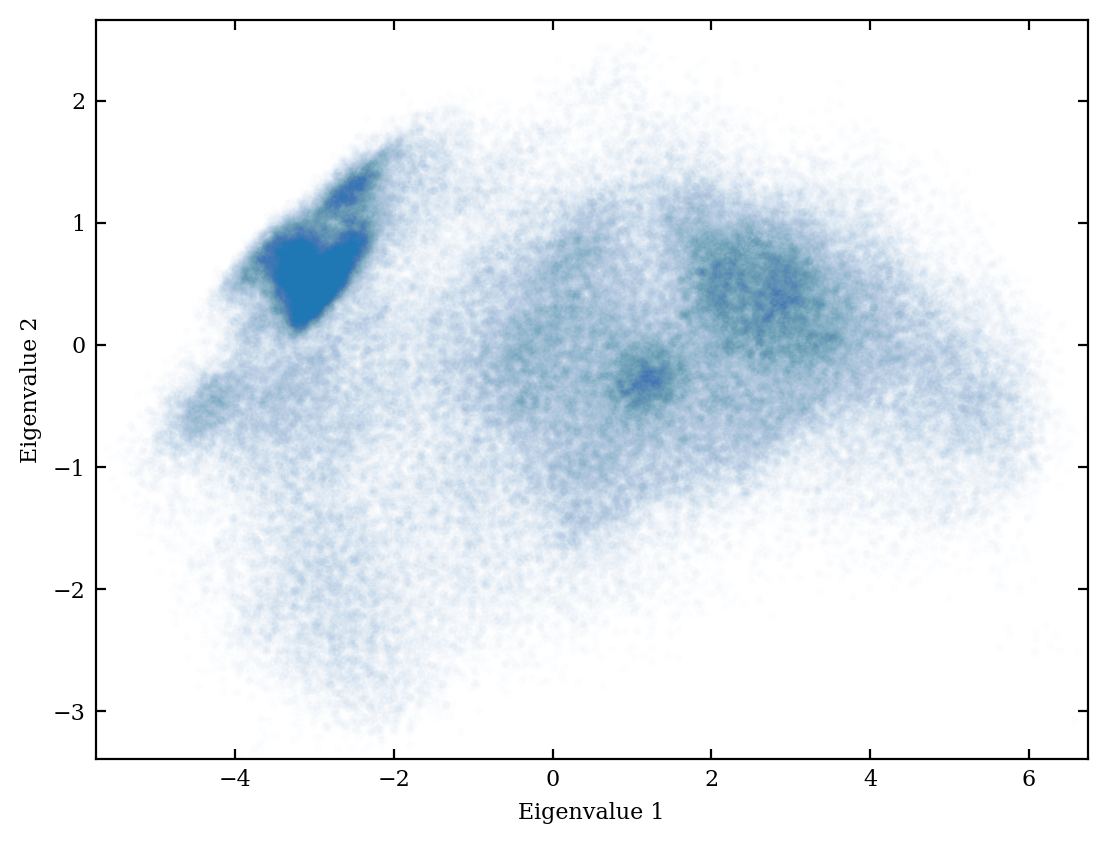

In [18]:
# Project onto 2 axes with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # 2 components
pca.fit(X) # Do the fitting

X_reduced = pca.transform(X)

plt.scatter(X_reduced[:,0], X_reduced[:,1], 
            marker=".", color='C0', 
            alpha=0.01, edgecolors='None')
plt.xlabel('Eigenvalue 1')
plt.ylabel('Eigenvalue 2')
plt.show()

The above image shows the data projected into **two linear combinations that encompass the directions of greatest variance**. We'll do $K$-means clustering in these dimensions.

In [19]:
# Compute the KMeans clustering
n_clusters = 6
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(X_reduced))

KMeans(n_clusters=6)

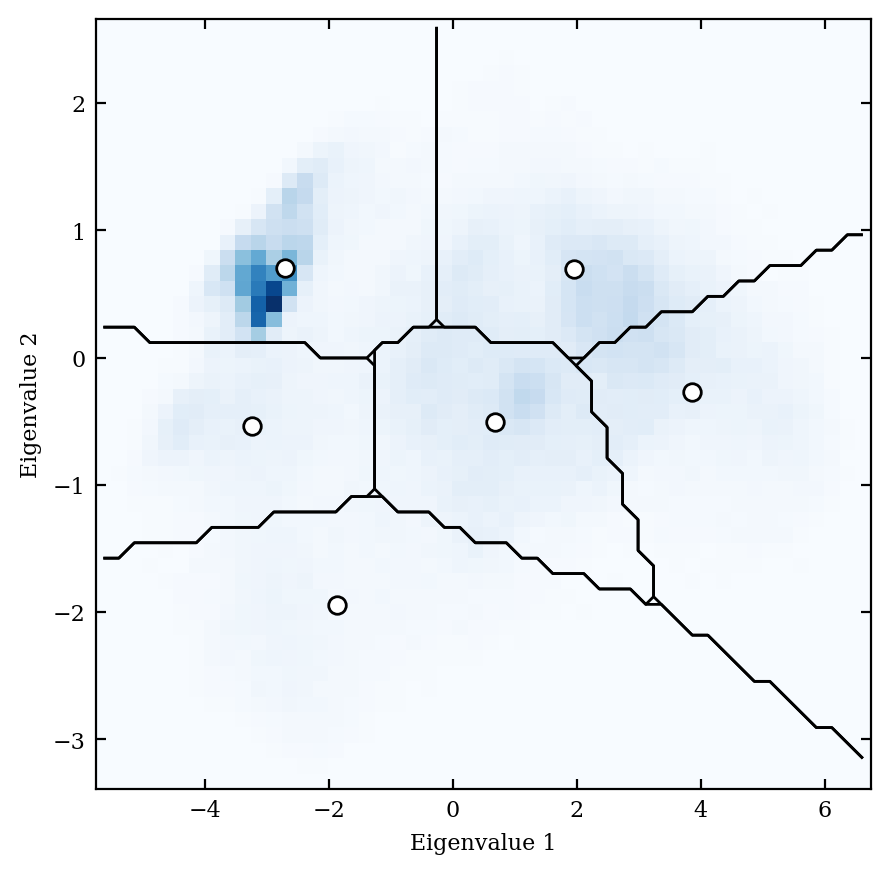

In [20]:
# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')

    H = clf.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

The above figure displays the underlying density of samples, the cluster centers, and the cluster boundaries! Very powerful!

### Mean-shift Clustering <a class="anchor" id="twob"></a>

**Mean-shift clustering** works by finding the modes in a kernel density estimator of the distribution. Clustering is achieved by the ***mean-shift algorithm***:

1. The KDE of the dataset is computed.
2. This allows the gradient of the distribution to be calculated. Easy to do since it's a bunch of overlapping Gaussians.
3. Each data point is shifted in the direction of increasing gradient, which drives the points toward the modes. 
4. This process is iterated until all points have converged with clusters of other points at each of several distinct modes.
5. Each data point is then associated with a cluster of other points.


Let's try this using the same dataset as in $K$-means.

In [23]:
# Compute the Mean-shift clustering
from sklearn.cluster import MeanShift

scaler = preprocessing.StandardScaler()
bandwidth = 0.4
#bandwidth = estimate_bandwidth(X_reduced) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=True, 
               cluster_all=False)
ms.fit(scaler.fit_transform(X_reduced))

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False)

[-1  0  1  2  3  4  5  6]
0.4
number of estimated clusters : 7


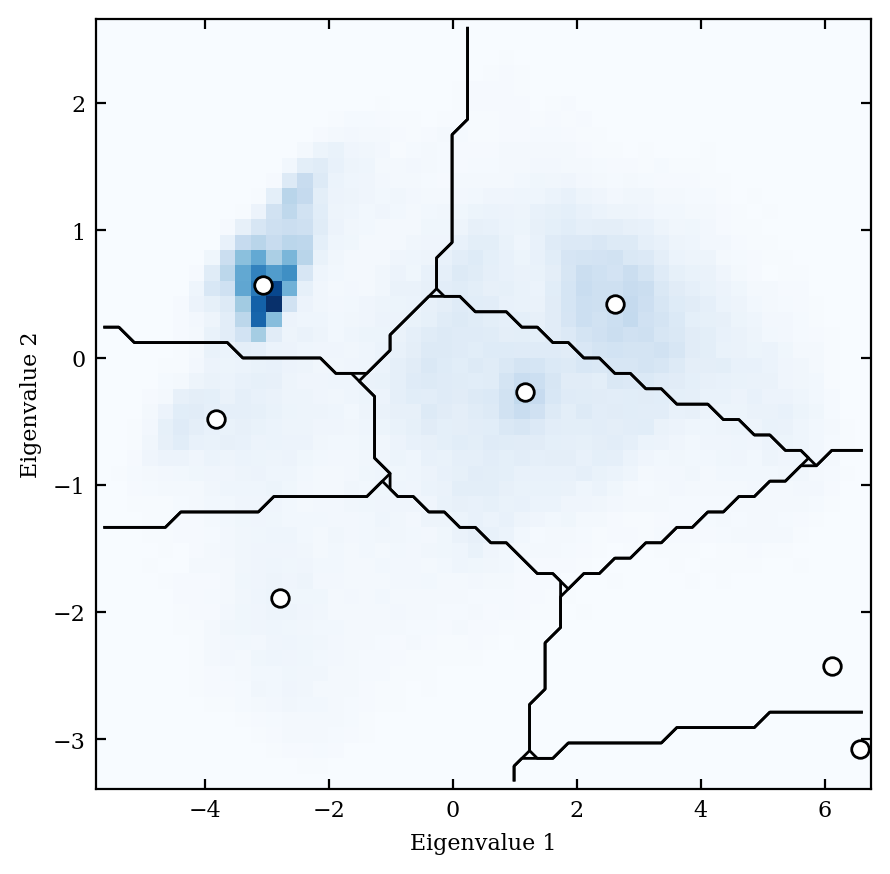

In [24]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_reduced[:,0], X_reduced[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],
                  yedges[0], yedges[-1]],
          cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('Eigenvalue 1')
ax.set_ylabel('Eigenvalue 2')

plt.show()

Mean-shift will not only estimate cluster centers and boundaries, but also the number of clusters!

**Summary of Chapter 6 methods from Ivezic Table 6.1. Entries correspond to (L)ow, (M)edium, (H)igh.** 

|Method          |Accuracy|Interpretability|Simplicity|Speed|
|----------------|--------|----------------|----------|-----|
|K-nearest Neighbor| H | H | H | M |
|Kernel Density Estimation| H | H | H | H |
|Gaussian Mixture Models| H | M | M | M |
|Extreme Deconvolution| H | H | M | M |
||||||
|K-Means| L | M | H | M |
|Max-radius minimization| L | M | M | M |
|Mean shift| M | H | H | M |
|Hierarchical Clustering| H | L | L | L |

## Correlation functions <a class="anchor" id="three"></a>

> ***Correlation functions*** *tell us how far (and on what scales) a distribution of data samples differs from a random distribution.*

They have been used extensively in astrophysics, e.g., 
- examining fluctuations and structure on varying scales of the galaxy density distribution in terms of luminosity, galaxy type, age of the Universe.
- examining the two-point correlation function of temperature fluctuations of the cosmic microwave background to unveil the composition of the Universe.
- searching for long-timescale correlations in time-series data to examine noise in AGN lightcurves or find GW signals in pulsar-timing data.


![](https://www.astroml.org/_images/fig_corr_diagram_1.png)


One of the most prominent is the **two-point correlation function** which characterizes the excess probability of finding pairs of points at varying separations when compared to a random distribution. It can be described in terms of the power spectrum of fluctuations, $P(k)$ where $k=2\pi/\lambda$ and $\lambda$ is the scale/wavelength of the fluctuation:

$$ \xi(r) = \frac{1}{2\pi^2}\int dk\, k^2 P(k)\frac{\sin(kr)}{kr}.$$

This correlation function can be used to describe the density fluctuations of sources by

$$ \xi(r) = \left\langle \frac{\delta\rho(x)}{\rho}\frac{\delta\rho(x+r)}{\rho}\right\rangle,$$

where $\delta\rho(x)/\rho = (\rho-\bar\rho)/\rho$ is the density contrast relative to the mean $\bar\rho$ at position $x$.

In many situations in astronomy or cosmology, the spatial correlation function or angular correlation function is modeled as a power-law, e.g. $w(\theta) = (\theta/\theta_0)^\delta$ (this is astronomy after all, where power-laws rule supreme). Angular correlation functions are often used because we care about *projected structure* on different scales, rather than depth clustering, e.g., in the CMB this kind of angular clustering is indicative of fluctuations in the primordial density field that can unveil the composition of the Universe at the time of last scattering.

Higher $n$-point correlation functions can be computed (see the image above), but the two-point function is the most common. Why? When dealing with large populations of sources spread across the Universe, we can often invoke the central limit theorem to describe the statistical distribution of sources-- hence **correlations can be approximated as obeying Gaussian statistics, which are entirely defined by the mean and two-point correlators (i.e. the variance)**.

In [25]:
# Execute this cell to implement AstroML's two-point correlation function on some random data
from astroML.correlation import two_point_angular

RA = 40 * np.random.random(1000)
DEC = 10 * np.random.random(1000) # ra and dec in degrees

bins = np.linspace(0.1, 10.0, 11) # edges for the 10 bins to evaluate
corr = two_point_angular(RA, DEC, bins, method='landy-szalay')
print(corr)

[-0.01849837 -0.00928138  0.01304327  0.00750878  0.00093233 -0.00902025
  0.002767   -0.02028219 -0.00873393 -0.01024269]


Now try the example from Figure 6.17 of the textbook. This computes the angular correlation function for a subset of the SDDS spectroscopic galaxy sample in the range $0.08<z<0.12$. This may take a minute or so to run.

data size:
  red gals:  38017
  blue gals: 16883
@pickle_results: using precomputed results from 'correlation_functions.pkl'


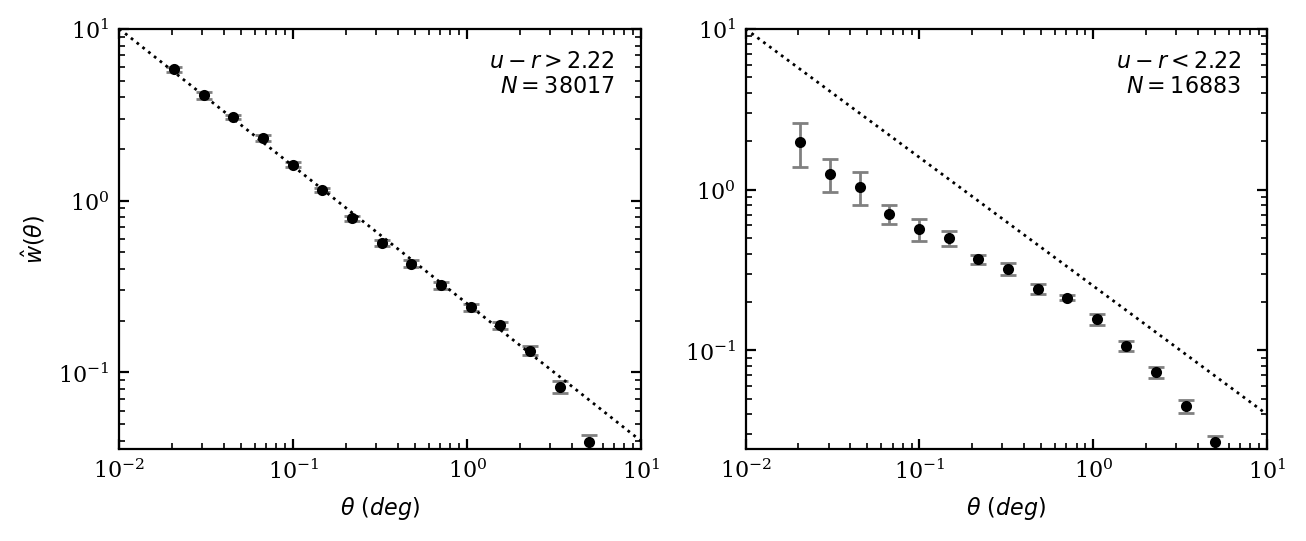

In [27]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function, division

from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular

#------------------------------------------------------------
# Get data and do some quality cuts
data = fetch_sdss_specgals()
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]

# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

data_red = data[flag_red]
data_blue = data[flag_blue]

print("data size:")
print("  red gals: ", len(data_red))
print("  blue gals:", len(data_blue))


#-----------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functions.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps,
 b_corr, b_corr_err, b_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

#------------------------------------------------------------
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(7, 3))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')


plt.show()

The left panel shows red galaxies with $u-r>2.22$ and the right panel shows blue galaxies with $u-r<2.22$. Uncertainties are derived from $10$ bootstrap samplings. There is significantly greater correlation structure on small angular scales in red galaxies than in blue galaxies. 

With tens of thousands of galaxies in each sample, this code has been optimized using **Scikit-Learn's ball-tree method for computing the correlation function-- further details given in Chapter 2, Section 2.52**.